In [4]:
from pathlib import Path
import pickle
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.cluster import DBSCAN
import simplekml
from smount_predictors import SeamountHelp
import xarray as xr

In [5]:
points = SeamountHelp.readKMLbounds(Path('data/Seamount_training_zone.kml'))
data = SeamountHelp.readAndFilterGRD(Path('data/vgg_swot.grd'), points[:2], points[2:])

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [16]:
np.unique(data['cluster'])

array([        -1,         56,         57, ..., 1149387103, 1149387104,
       1149387105])

In [ ]:
mounts = data.groupby('cluster').mean().reset_index()
kml = simplekml.Kml()
for i, row in mounts.iterrows():
    kml.newpoint(name=f'{row.cluster}', coords=[(row.lon, row.lat, row.z)])
kml.save('out/global_mounts.kml')

In [11]:
mask = xr.open_dataarray('data/depth_mask.grd')
# np.unique(mask.values)
mask.values

array([[ 1.,  1.,  1., ..., nan,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan,  1.,  1.],
       ...,
       [ 0.,  0.,  0., ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan,  0.,  0.]], dtype=float32)

In [12]:
srtm = xr.open_dataarray('data/srtm_swotsize.grd')
srtm.values

array([[   50.5   ,    50.5   ,    51.25  , ...,        nan,    49.5   ,
           49.75  ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [   49.    ,    50.    ,    50.5   , ...,        nan,    49.    ,
           49.    ],
       ...,
       [-1577.6608, -1568.7339, -1564.4452, ...,        nan, -1587.4585,
        -1584.2736],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1557.6478, -1552.5125, -1547.5945, ...,        nan, -1564.1993,
        -1561.5991]], dtype=float32)

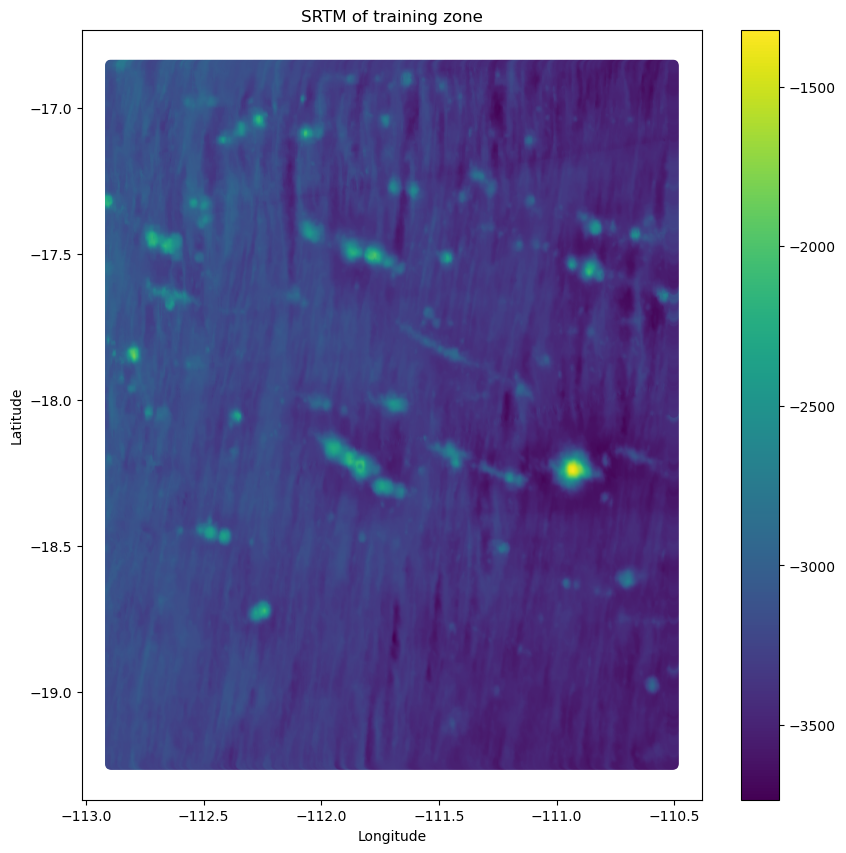

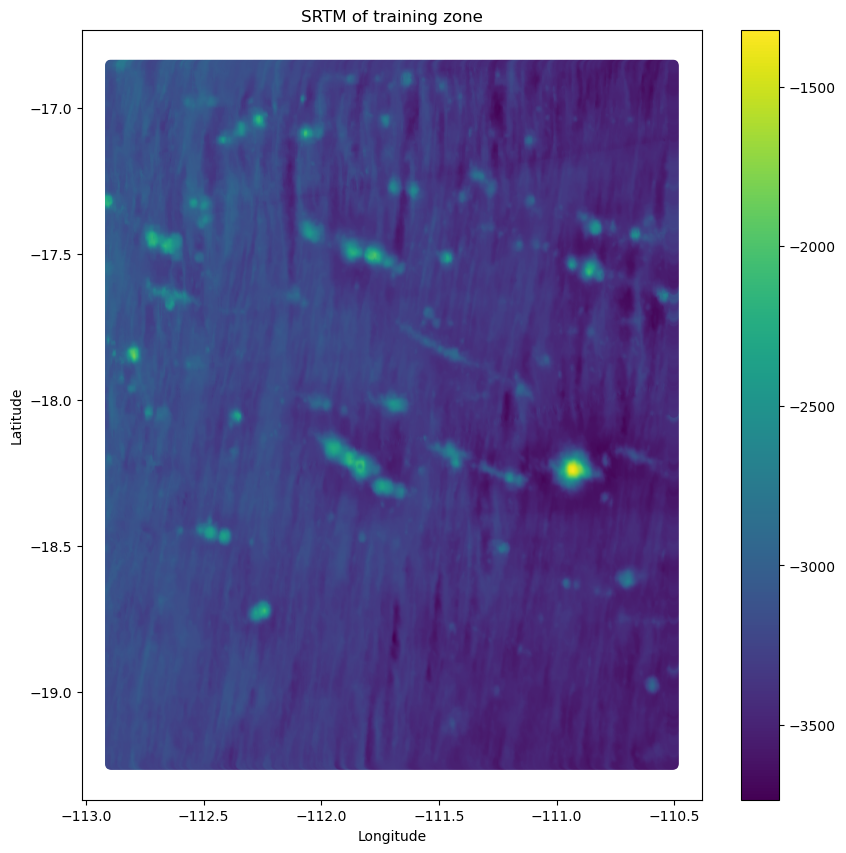

In [4]:
srtm = SeamountHelp.readAndFilterGRD(Path("data/SRTM15_V2.5.nc"), points[:2], points[2:])
SeamountHelp.plot_xarr(srtm, name="SRTM of training zone", backend='plt')

In [6]:
datadf = data.to_dataframe().reset_index()
bigmount = datadf[(datadf['lat'] >= -18.6) & (datadf['lat'] <= -18.0) & (datadf['lon'] >= -111.2) & (datadf['lon'] <= -110.6)]
px.scatter(bigmount, x='lon', y='lat', color='z')

In [7]:
px.scatter_3d(bigmount, x='lon', y='lat', z='z')

In [10]:
import pickle
from smount_predictors.src.SeamountHelp import PipelinePredictor
from sklearn.preprocessing import StandardScaler
model = pickle.load(open('out/cluster_tuned_model.pkl', 'rb'))
svc_model = model.model
threshold = -svc_model.named_steps['predictor'].intercept_[0] / svc_model.named_steps['predictor'].coef_[0][0]
print("Threshold for the hyperplane:", threshold)

Threshold for the hyperplane: 0.30986633119755375


In [14]:
svc_model.named_steps['predictor'].coef_

array([[2.47695002]])

In [34]:
from smount_predictors import SeamountTransformer
trans = SeamountTransformer()
trans.fit_transform(bigmount)

array([[-0.22540695],
       [-0.22562493],
       [-0.22580225],
       ...,
       [-0.22543854],
       [-0.22530914],
       [-0.22524383]])

In [38]:
np.array([[svc_model.named_steps['predictor'].coef_[0][0],], [svc_model.named_steps['predictor'].intercept_[0],]])

array([[ 2.47695002],
       [-0.76752342]])

In [37]:

model.model.predict()

ValueError: Shape of passed values is (2, 1), indices imply (2, 3)

In [40]:
import plotly.graph_objects as go
fig = px.scatter_3d(bigmount, x='lon', y='lat', z='z')
plane = go.Surface(
    z=2.47695002 * np.ones_like(xx),
    x=xx,
    y=yy,
    colorscale=[[0, 'green'], [1, 'green']],
    opacity=0.5,
    showscale=False
)
fig.add_trace(plane)
fig.update_layout(
    autosize=False,
    width=900,
    height=800
)
fig.show()
